### 通し課題 : Car Fuel Consumption (２回目)
- 100Kmあたりのガソリン消費量(consume)を予測する
- 不明点
    - 説明変数が複数ある今回のようなデータの場合に、正則化の評価をどのようにすれば良いかわかりませんでした。


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

### データの準備

In [2]:
# CSVファイルを読み込む
df_consume = pd.read_csv("../1_data/measurements.csv")

In [3]:
df_consume.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


In [4]:
# 分析に使えない列を削除する
df_consume_ext = df_consume.drop(["specials", "refill liters", "refill gas"], axis=1)

In [5]:
# , を .に置換する
df_consume_ext["distance"] = df_consume_ext["distance"].str.replace(",", ".")
df_consume_ext["consume"] = df_consume_ext["consume"].str.replace(",", ".")
df_consume_ext["temp_inside"] = df_consume_ext["temp_inside"].str.replace(",", ".")

In [6]:
# 型を変換する
df_consume_ext["distance"] = df_consume_ext["distance"].astype(float)
df_consume_ext["consume"] = df_consume_ext["consume"].astype(float)
df_consume_ext["temp_inside"] = df_consume_ext["temp_inside"].astype(float)
df_consume_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 9 columns):
distance        388 non-null float64
consume         388 non-null float64
speed           388 non-null int64
temp_inside     376 non-null float64
temp_outside    388 non-null int64
gas_type        388 non-null object
AC              388 non-null int64
rain            388 non-null int64
sun             388 non-null int64
dtypes: float64(3), int64(5), object(1)
memory usage: 27.4+ KB


In [7]:
# consumeが第１列にくるよう列の順番を入れ替える
df_consume_ext = df_consume_ext.iloc[:,[1,0,2,3,4,5,6,7,8]]

In [8]:
# 目的変数(consume)を格納する
y = df_consume_ext["consume"].values
# 説明変数(consume以外)を格納する（temp_insideはレコード数が足りてないので除外した。）
X = df_consume_ext[['distance', 'speed', 'temp_outside', 'AC', 'rain', 'sun']].values

In [9]:
# データを確認する
df_consume_ext.describe()

,consume,distance,speed,temp_inside,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000
mean,4.912371,19.652835,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474
std,1.033172,22.667837,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441
min,3.300000,1.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000
25%,4.300000,11.800000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000
50%,4.700000,14.600000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000
75%,5.300000,19.000000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000
max,12.200000,216.100000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000


## ホールドアウト法の確認
- 中で標準化を実施

In [10]:
# データを学習用と検証用に分ける
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)

(array([243.,  51.,   7.,   2.,   3.,   0.,   2.,   1.,   0.,   1.]),
 array([  1.3 ,  22.27,  43.24,  64.21,  85.18, 106.15, 127.12, 148.09,
        169.06, 190.03, 211.  ]),
 <a list of 10 Patch objects>)

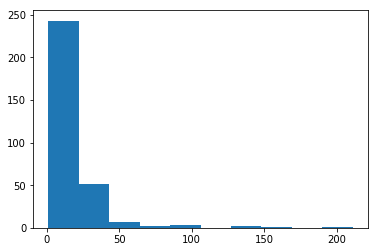

In [11]:
# 標準化前の値を確認する
plt.hist(X_train[:,0])

In [12]:
# 標準化を行う
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.transform(X_train)
X_test_std = stdsc.transform(X_test)

(array([243.,  51.,   7.,   2.,   3.,   0.,   2.,   1.,   0.,   1.]),
 array([-0.87919898,  0.12456091,  1.1283208 ,  2.13208069,  3.13584058,
         4.13960047,  5.14336036,  6.14712025,  7.15088014,  8.15464003,
         9.15839992]),
 <a list of 10 Patch objects>)

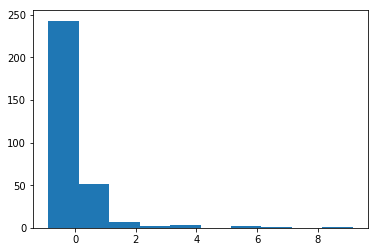

In [13]:
# 標準化後の値を確認する
plt.hist(X_train_std[:,0])

In [14]:
# 学習用データで学習する
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train_std,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
# 学習用データの訓練誤差を評価する
y_train_est = regr.predict(X_train_std)

# 実際のconsumeとの2乗誤差の平均を算出する
mse = mean_squared_error(y_train, y_train_est)
print("MSE(訓練)={:.3f}".format(mse))

#絶対値の差の平均を算出する
mae = mean_absolute_error(y_train, y_train_est)
print("MAE(訓練)={:.3f}".format(mae))
#MSEの平方根を算出する
rmse = np.sqrt(mse)
print("RMSE(訓練)={:.3f}".format(rmse))

MSE(訓練)=0.900
MAE(訓練)=0.617
RMSE(訓練)=0.949


- DAY1での評価指標は以下のようでした。この例では正規化後も大きく変動していないように見えます。
- MSE=0.892
- MAE=0.607
- RMSE=0.944

In [16]:
# 汎化誤差を評価する
y_test_est = regr.predict(X_test_std)

# 実際のconsumeとの2乗誤差の平均を算出する
mse = mean_squared_error(y_test, y_test_est)
print("MSE(汎化)={:.3f}".format(mse))

#絶対値の差の平均を算出する
mae = mean_absolute_error(y_test, y_test_est)
print("MAE(汎化)={:.3f}".format(mae))
#MSEの平方根を算出する
rmse = np.sqrt(mse)
print("RMSE(汎化)={:.3f}".format(rmse))

MSE(汎化)=0.663
MAE(汎化)=0.657
RMSE(汎化)=0.814


## 交差検証法の確認

In [17]:
# 学習データを５つに分割し、テストデータを変えて５回誤差を算出する
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
mae_accum = 0

for train_idx, test_idx in kf.split(X, y):
    X_train = X[train_idx]
    X_test = X[test_idx]
    # 標準化を行う
    stdsc = StandardScaler()
    stdsc.fit(X_train)
    X_train_std = stdsc.transform(X_train)
    X_test_std = stdsc.transform(X_test)
    y_train = y[train_idx]
    y_test = y[test_idx]
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train_std, y_train)
    y_est = regr.predict(X_test_std)
    mae = mean_absolute_error(y_test, y_est)
    print('MAE=%s'%round(mae,3))
    mae_accum += mae
average_mae = mae_accum / 5
print('MAE(平均)=%s'%round(average_mae,3))

MAE=0.657
MAE=0.621
MAE=0.735
MAE=0.592
MAE=0.514
MAE(平均)=0.624


- 5回の結果がばらついているので、交差検証法が必要と思います。

## 正則化の確認
- トライはしたのですが、よくわからない結果になりました。

In [18]:
# speedを横軸にしてconsumeを描画してみる
def plot_approximation(est, ax, label=None):
    y_est = est.predict(X_test)
    speed = X_test[:,1]
    ax.scatter(speed,y_est,s=10)#　実際の値
    ax.scatter(speed,y_test,s=10,color='r', label=label)#予測値
    ax.set_xlabel('speed')
    ax.set_ylabel('consume')
    ax.set_ylim((0,13))
    ax.legend(loc="upper right")
    
def plot_coefficients(est, ax, label=None, yscale='log'):
    coef = est.steps[-1][1].coef_.ravel()
    coef_abs = np.abs(coef)
    ax.plot(coef_abs, marker='o', label=None)
    ax.set_xlabel('coefficients')
    ax.set_ylabel('abs(coefficients)')

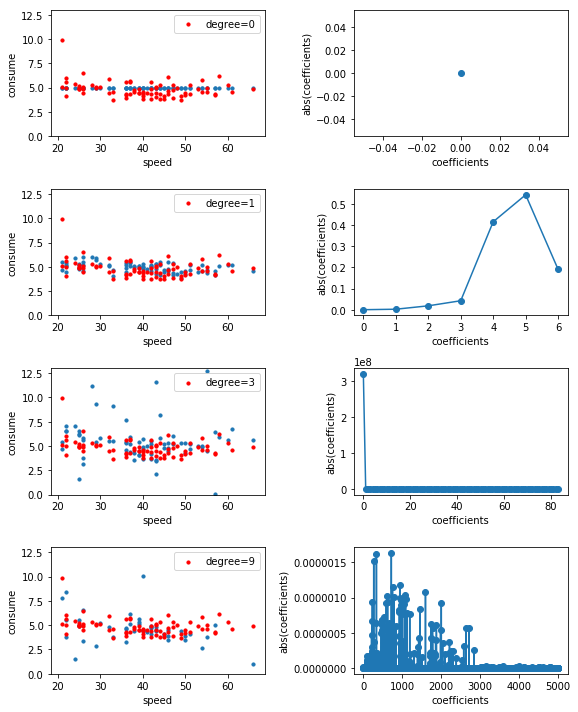

In [19]:
# 正則化項なしの場合
fig, ax_rows = plt.subplots(4,2,figsize=(8,10))    
degrees=[0,1,3,9]
for ax_row, degree in zip(ax_rows, degrees):
    ax_left, ax_right = ax_row
    # 説明変数が複数の場合に使えるのかわからないがやってみる
    est = make_pipeline(PolynomialFeatures(degree),LinearRegression())
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='degree=%d' % degree)
    plot_coefficients(est, ax_right, yscale=None)
    
plt.tight_layout()

C:\Users\s97z411\Miniconda3\envs\skillupai2\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\s97z411\Miniconda3\envs\skillupai2\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\s97z411\Miniconda3\envs\skillupai2\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\s97z411\Miniconda3\envs\skillupai2\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

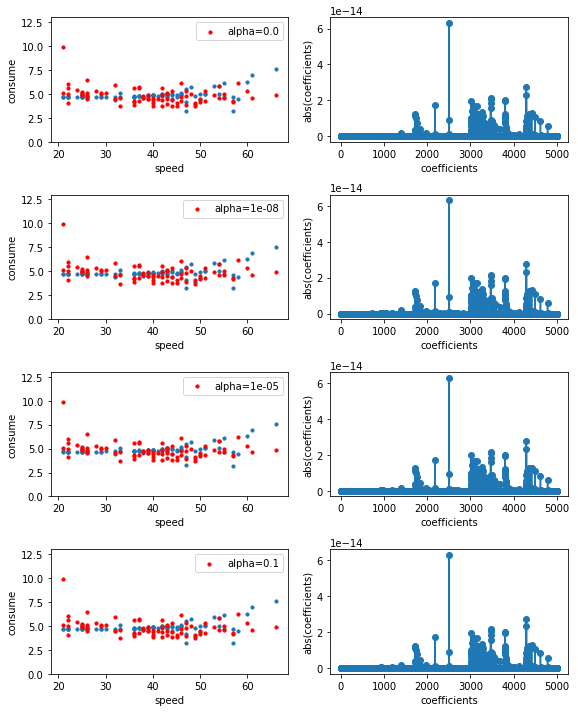

In [20]:
# Ridgeを試してみる
fig, ax_rows = plt.subplots(4,2,figsize=(8,10))    
degree=9
alphas = [0.0, 1e-8, 1e-5, 1e-1]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    # 説明変数が複数の場合に使えるのかわからないがやってみる
    est = make_pipeline(PolynomialFeatures(degree),Ridge(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)
    
plt.tight_layout()

- エラーが出てしまい解決できませんでした。

### 無相関化の確認

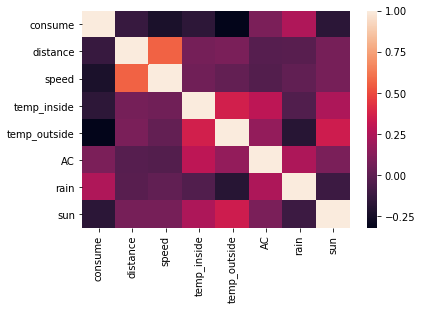

In [21]:
# 相関係数を確認する
sns.heatmap(df_consume_ext.corr())

- この中ではdistanceとspeedの相関が一番大きい。

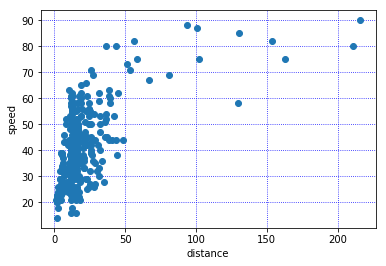

In [22]:
# distanceとspeedを描画してみる
plt.plot(X[:,0], X[:,1], 'o')
plt.xlabel('distance')
plt.ylabel('speed')
plt.grid(which='major', color='blue', linestyle=':')
plt.show()

In [23]:
# 相関係数を算出
soukan = np.corrcoef(X[:,0], X[:,1])
print("相関係数={:.3f}".format(soukan[0,1]))

相関係数=0.562


In [24]:
# distanceとspeedを抽出する
data1 = np.zeros([len(X[:,0]),2])
data1[:,0] = X[:,0]
data1[:,1] = X[:,1]

In [25]:
# 共分散行列を求める
cov = np.cov(data1, rowvar=0)

In [26]:
# 固有値、固有ベクトルを求める
koyuu, koyuu_vector = np.linalg.eig(cov)
koyuu_vector

array([[ 0.91877518, -0.39478116],
       [ 0.39478116,  0.91877518]])

In [27]:
# 固有ベクトルの転置行列とdistance、speedを格納した388行の行列を転置したものの内積をとり、さらにそれを転置する
kekka = np.dot(koyuu_vector.T, data1.T).T
# 再度相関計数を求める
soukan = np.corrcoef(kekka[:,0], kekka[:,1])
print("相関係数={:.3f}".format(soukan[0,1]))

相関係数=-0.000


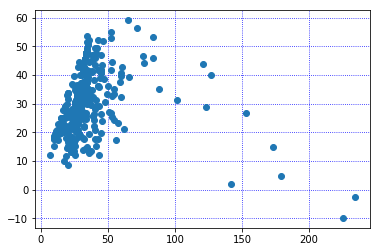

In [28]:
plt.plot(kekka[:,0], kekka[:,1],'o')
plt.grid(which='major', color='blue', linestyle=':')
plt.show()

- 一見相関しているようにも見えるが、相関係数は小さくなっている。

### 白色化の確認

In [29]:
stdsc = StandardScaler()

In [30]:
stdsc.fit(kekka)
kekka_stan = stdsc.transform(kekka)
# 再度相関計数を求める
soukan = np.corrcoef(kekka_stan[:,0], kekka_stan[:,1])

In [31]:
print("相関係数={:.3f}".format(soukan[0,1]))

相関係数=-0.000


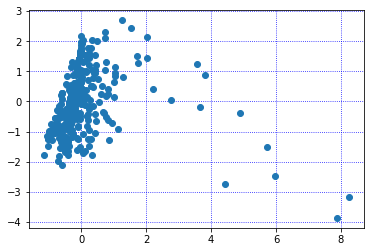

In [32]:
plt.plot(kekka_stan[:,0], kekka_stan[:,1],'o')
plt.grid(which='major', color='blue', linestyle=':')
plt.show()